<a href="https://colab.research.google.com/github/Neix20/Deep_Learning_May_2021/blob/main/Fashion_Product_Small_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Notebook to Google Colab Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Change Directory

In [ ]:
cd /content/drive/MyDrive/Deep_Learning_Assignment_May_2021/Deep_Learning_May_2021

/content/drive/MyDrive/Deep_Learning_Assignment_May_2021/Deep_Learning_May_2021


## Load Libraries

In [ ]:
import matplotlib
import numpy as np
import torch.nn as nn
import torch, torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models

from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Create Dataset Classes
This is to transform any dataset we import into a class that can be processed by our model


### 0. Fashion MNIST Dataset

In [ ]:
class FashionMNIST(Dataset):
    
    def __init__(self, root = ".", train = True, download=False, transform=None, num_samples = None):
        self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.num_classes = len(self.classes)            

        self.__dataset = torchvision.datasets.FashionMNIST(root=root, train=train, download=download, transform=transform)
			
        self.__num_samples = min(num_samples, len(self.__dataset)) if num_samples is not None else len(self.__dataset)
                       
    def __len__(self):
        return self.__num_samples
    
    def __getitem__(self, idx):            
        return self.__dataset[idx]

## Fetch Dataset

In [ ]:
dataset = FashionMNIST(root=".", download= True)

Using downloaded and verified file: ./FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw

Using downloaded and verified file: ./FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Original Image

In [ ]:
def show_image(img):
    plt.imshow (img, cmap = matplotlib.cm.gray, interpolation = 'nearest')

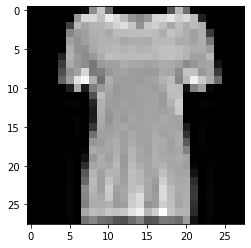

In [ ]:
idx = 10
img, label = dataset[idx]

show_image(img)

## Transformation Pipeline
* Resize image to Standard Image Size (224, 224)
* Convert Tensor Pil Image to Tensor
* Normalize Image to Tensor Float
* _Data Augmentation (Extra): Random Crop_
* _Data Augmentation (Extra): Random Horizontal Flip_


In [ ]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(28),                            
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [ ]:
fashion_MNIST_transform = transforms.Compose([              
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [ ]:
idx = 10
img, label = dataset[idx]

# tmp = transform(img)
tmp = fashion_MNIST_transform(img)

print('Shape of img:', tmp.shape)
print(f'Range of img: {tmp.min().item():.2f} to {tmp.max().item():.2f}')
print('Type of img:', type(tmp))
print('Type of items in img:', tmp.dtype)

TypeError: ignored

In [ ]:
dataset = FashionMNIST(root=".", download= True, transform = fashion_MNIST_transform)

## Split Dataset Into Train Set and Trainning Set

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset, [50000, 10000])

## Batch Loader

In [ ]:
trainloader = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testloader = DataLoader(testset, batch_size = 4, shuffle = True, num_workers = 2)

## Train Function

#### Train Pipeline:

* Optimizer => Used to update parameters after forward-backward Propagation
* Loss Function => Used to update the direction of the gradient
* The following train Model uses Gradient Descent algorithm. The gradient descent algorithm has the following pipeline.
  * Forward Propagation
  * Update Gradient to backwards
  * Backward Propagation

In [ ]:
def train(model, trainloader, num_epochs = 25, loss_iter = 50, lr=0.1, momentum=0.9, verbose=True):
    history = {}
    
    loss_iterations = int(np.ceil(len(trainloader)/loss_iter))
    
    # Define Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # set to training mode
    model.train()

    # train the network
    for e in range(num_epochs):    

        running_loss, running_count = 0.0, 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to 0
            optimizer.zero_grad()

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            outs = model(inputs)
            loss = F.cross_entropy(outs, labels)
            loss.backward()
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1
            train_loss = 0

             # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                train_loss = running_loss / running_count
                running_loss, running_count = 0.0, 0.0
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')       
        
      history[f'{e+1:2d}'] = train_loss
    return history

## Evaluate Model Performance

In [ ]:
def evaluate(model, testloader):
    
    # set to evaluation mode
    model.eval()

    # Define Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # running_correct
    running_corrects = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # # disable gradient computation
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (targets == predicted).double().sum()


    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))

## 2. VGG Net Model

<center><b><font>VGG16 Model</font></b></center>

Notes: `k`: number of filters, `f`: filter or kernel size, `s`: stride, `p`: padding, `o`: output shape

In [ ]:
def build_vgg16_network(pretrained = True):
  model =  models.vgg16_bn(pretrained = pretrained)
  model.classifier = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Linear(in_features=4096, out_features=10, bias=True),
  )
  return model

### Pretrained

In [ ]:
model = build_vgg16_network(False)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# history1 = train(model, trainloader, lr = 0.001, momentum = 0.9, verbose = True)

In [ ]:
# evaluate(model, testloader)

## 3. Convoluted Network Model I

<center><b><font>Convoluted CNN</font></b></center>

|Layer|Name|Description|Output Shape|
|--- |--- |--- |--- |
|1|conv1|Conv2d(k=32,f=5,s=1,p=1)|(?, 32, 28, 28)|
|-|ReLU|ReLU(inplace=True)|(?, 32, 28, 28)|
|-|Max Pool|max_pool2d(x,k=2,s=1,p=0)|(?, 32, 14, 14)|
|2|conv1|Conv2d(k=64,f=2,s=1,p=1)|(?, 64, 14, 14)|
|-|ReLU|ReLU(inplace=True)|(?, 64, 14, 14)|
|-|Max Pool|max_pool2d(x,k=2,s=2,p=0)|(?, 64, 7, 7)|
|3|conv1|Conv2d(k=128,f=3,s=1,p=1)|(?, 128, 7, 7)|
|-|ReLU|ReLU(inplace=True)|(?, 128, 7, 7)|
|-|Max Pool|max_pool2d(x,k=2,s=2,p=0)|(?, 128, 3, 3)|
|4|fc1|Linear(#units=1,152)|(?, 1152)|
|-|ReLU|ReLU(inplace=True)|(?, 1152)|
|4|fc1|Linear(#units=1,152)|(?, 10)|
|-|ReLU|ReLU(inplace=True)|(?, 10)|

Notes: `k`: number of filters, `f`: filter or kernel size, `s`: stride, `p`: padding, `o`: output shape

In [ ]:
def build_block_cnn(in_channels, out_channels):
  block = nn.Sequential(
    nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU()
  )
  return block

In [ ]:
class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()

        channel_size = [3, 32, 32]
        layer_size = [32 * 7 * 7, 128, 10]
        p = 0.25
        
        # define blocks
        self.conv_block = nn.ModuleList(
            build_block_cnn(in_channel, out_channel) for(in_channel, out_channel) in zip(channel_size[0:-1], channel_size[1:])
        )
        
        # define fc1
        self.fc = nn.ModuleList(
            [nn.Linear(in_channel, out_channel) for(in_channel, out_channel) in zip(layer_size[0:-1], layer_size[1:])]
        )

        # Dropout
        self.dropout = nn.ModuleList(
            [nn.Dropout(p) for i in range(len(layer_size) - 2)]
        )
        
    def forward(self, x):
        for block in self.conv_block:
          x = F.max_pool2d(block(x), kernel_size = 2, stride = 2, padding = 0)

        x = x.view(x.size(0), -1)

        for (dropout, fc) in zip(self.dropout, self.fc[:-1]):
          x = dropout(torch.relu(fc(x)))
        
        x = torch.relu(self.fc[1](x))
        
        return x

In [ ]:
model = cnn_model()
print(model)

cnn_model(
  (conv_block): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.25, inplace=False)
  )
)


In [ ]:
summary(model, (3, 28, 28), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
              ReLU-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 128]         200,832
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 212,266
Trainable params: 212,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.30
----------------------------------------------------------------


In [ ]:
history1 = train(model, trainloader, num_epochs = 15, loss_iter = 50, lr = 0.001, momentum = 0.9, verbose = True)

[Epoch  1/25 Iter   250/12500]: train_loss = 2.2851
[Epoch  1/25 Iter   500/12500]: train_loss = 2.0229
[Epoch  1/25 Iter   750/12500]: train_loss = 1.4851
[Epoch  1/25 Iter  1000/12500]: train_loss = 1.3051
[Epoch  1/25 Iter  1250/12500]: train_loss = 1.3338
[Epoch  1/25 Iter  1500/12500]: train_loss = 1.1804
[Epoch  1/25 Iter  1750/12500]: train_loss = 1.0646
[Epoch  1/25 Iter  2000/12500]: train_loss = 1.1032
[Epoch  1/25 Iter  2250/12500]: train_loss = 1.0371
[Epoch  1/25 Iter  2500/12500]: train_loss = 0.9930
[Epoch  1/25 Iter  2750/12500]: train_loss = 1.0096
[Epoch  1/25 Iter  3000/12500]: train_loss = 0.9523
[Epoch  1/25 Iter  3250/12500]: train_loss = 1.0088
[Epoch  1/25 Iter  3500/12500]: train_loss = 0.9626
[Epoch  1/25 Iter  3750/12500]: train_loss = 0.8774
[Epoch  1/25 Iter  4000/12500]: train_loss = 0.9490
[Epoch  1/25 Iter  4250/12500]: train_loss = 0.8639
[Epoch  1/25 Iter  4500/12500]: train_loss = 0.8821
[Epoch  1/25 Iter  4750/12500]: train_loss = 0.8439
[Epoch  1/25

In [ ]:
evaluate(model, testloader)

Accuracy = 91.66%


## 4. Convoluted Model II


In [ ]:
class cnn_model2(nn.Module):
    def __init__(self):
        super().__init__()

        channel_size = [3, 32, 32]
        layer_size = [32 * 7 * 7,128, 10]
        p = 0.25
        
        # define blocks
        self.conv_block = nn.ModuleList(
            build_block_cnn(in_channel, out_channel) for(in_channel, out_channel) in zip(channel_size[0:-1], channel_size[1:])
        )
        
        # define Fully Connected Layers
        self.fc = nn.ModuleList(
            [nn.Linear(in_channel, out_channel) for(in_channel, out_channel) in zip(layer_size[0:-1], layer_size[1:])]
        )

        # Define Dropout
        self.dropout = nn.ModuleList(
            [nn.Dropout(p) for i in range(len(layer_size) - 2)]
        )

        # Define Batch Normalization
        self.bn = nn.ModuleList(
            [nn.BatchNorm2d(i) for i in channel_size[:-1]]
        )
        
    def forward(self, x):
        for (bn, block) in zip(self.bn, self.conv_block):
          x = F.max_pool2d(block(bn(x)), kernel_size = 2, stride = 2, padding = 0)

        x = x.view(x.size(0), -1)

        for (dropout, fc) in zip(self.dropout, self.fc[:-1]):
          x = dropout(torch.relu(fc(x)))
        
        x = torch.relu(self.fc[1](x))
        
        return x

In [ ]:
model = cnn_model2()
print(model)

cnn_model2(
  (conv_block): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.25, inplace=False)
  )
  (bn): ModuleList(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
summary(model, (3, 28, 28), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 28, 28]               6
            Conv2d-2           [-1, 32, 28, 28]             896
              ReLU-3           [-1, 32, 28, 28]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
            Conv2d-5           [-1, 32, 14, 14]           9,248
              ReLU-6           [-1, 32, 14, 14]               0
            Linear-7                  [-1, 128]         200,832
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 212,336
Trainable params: 212,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 0.81
Estimated Total Size (MB): 1.37
-------------------------------------------

In [ ]:
history2 = train(model, trainloader, num_epochs = 10, loss_iter = 50, lr = 0.001, momentum = 0.9, verbose = True)

[Epoch  1/10 Iter   250/12500]: train_loss = 1.7692
[Epoch  1/10 Iter   500/12500]: train_loss = 0.9567
[Epoch  1/10 Iter   750/12500]: train_loss = 0.8299
[Epoch  1/10 Iter  1000/12500]: train_loss = 0.7366
[Epoch  1/10 Iter  1250/12500]: train_loss = 0.7991
[Epoch  1/10 Iter  1500/12500]: train_loss = 0.6725
[Epoch  1/10 Iter  1750/12500]: train_loss = 0.6571
[Epoch  1/10 Iter  2000/12500]: train_loss = 0.6358
[Epoch  1/10 Iter  2250/12500]: train_loss = 0.7141
[Epoch  1/10 Iter  2500/12500]: train_loss = 0.6455
[Epoch  1/10 Iter  2750/12500]: train_loss = 0.5972
[Epoch  1/10 Iter  3000/12500]: train_loss = 0.5826
[Epoch  1/10 Iter  3250/12500]: train_loss = 0.6375
[Epoch  1/10 Iter  3500/12500]: train_loss = 0.6026
[Epoch  1/10 Iter  3750/12500]: train_loss = 0.5795
[Epoch  1/10 Iter  4000/12500]: train_loss = 0.5443
[Epoch  1/10 Iter  4250/12500]: train_loss = 0.5564
[Epoch  1/10 Iter  4500/12500]: train_loss = 0.6172
[Epoch  1/10 Iter  4750/12500]: train_loss = 0.5335
[Epoch  1/10

In [ ]:
evaluate(model, testloader)

Accuracy = 88.58%


## 5. Convolution Model III


In [ ]:
class cnn_model3(nn.Module):
    def __init__(self):
        super().__init__()

        channel_size = [3, 32, 32]
        layer_size = [32 * 7 * 7, 128, 10]
        p = 0.25
        
        # define blocks
        self.conv_block = nn.ModuleList(
            build_block_cnn(in_channel, out_channel) for(in_channel, out_channel) in zip(channel_size[0:-1], channel_size[1:])
        )
        
        # define Fully Connected Layers
        self.fc = nn.ModuleList(
            [nn.Linear(in_channel, out_channel) for(in_channel, out_channel) in zip(layer_size[0:-1], layer_size[1:])]
        )

        # Define Dropout
        self.dropout = nn.ModuleList(
            [nn.Dropout(p) for i in range(len(layer_size) - 2)]
        )

        # Define Batch Normalization
        self.bn = nn.ModuleList(
            [nn.BatchNorm2d(i) for i in channel_size[:-1]]
        )
        
    def forward(self, x):
        residual = self.bn[0](x)
        tmp = self.conv_block[0](residual)
        x = F.max_pool2d(tmp, kernel_size = 2, stride = 2, padding = 0)

        residual = self.bn[1](x)
        tmp = self.conv_block[1](residual)
        tmp += residual
        x = F.max_pool2d(tmp, kernel_size = 2, stride = 2, padding = 0)

        x = x.view(x.size(0), -1)

        for (dropout, fc) in zip(self.dropout, self.fc[:-1]):
          x = dropout(torch.relu(fc(x)))
        
        x = torch.relu(self.fc[1](x))
        
        return x

In [ ]:
model = cnn_model3()
print(model)

cnn_model3(
  (conv_block): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.25, inplace=False)
  )
  (bn): ModuleList(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
summary(model, (3, 28, 28), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 28, 28]               6
            Conv2d-2           [-1, 32, 28, 28]             896
              ReLU-3           [-1, 32, 28, 28]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
            Conv2d-5           [-1, 32, 14, 14]           9,248
              ReLU-6           [-1, 32, 14, 14]               0
            Linear-7                  [-1, 128]         200,832
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 212,336
Trainable params: 212,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 0.81
Estimated Total Size (MB): 1.37
-------------------------------------------

In [ ]:
history3 = train(model, trainloader, num_epochs = 10, loss_iter = 50, lr = 0.001, momentum = 0.9, verbose = True)

[Epoch  1/10 Iter   250/12500]: train_loss = 1.3620
[Epoch  1/10 Iter   500/12500]: train_loss = 0.8565
[Epoch  1/10 Iter   750/12500]: train_loss = 0.8290
[Epoch  1/10 Iter  1000/12500]: train_loss = 0.6938
[Epoch  1/10 Iter  1250/12500]: train_loss = 0.6465
[Epoch  1/10 Iter  1500/12500]: train_loss = 0.7209
[Epoch  1/10 Iter  1750/12500]: train_loss = 0.7283
[Epoch  1/10 Iter  2000/12500]: train_loss = 0.6626
[Epoch  1/10 Iter  2250/12500]: train_loss = 0.5994
[Epoch  1/10 Iter  2500/12500]: train_loss = 0.5994
[Epoch  1/10 Iter  2750/12500]: train_loss = 0.5770
[Epoch  1/10 Iter  3000/12500]: train_loss = 0.6463
[Epoch  1/10 Iter  3250/12500]: train_loss = 0.6060
[Epoch  1/10 Iter  3500/12500]: train_loss = 0.6446
[Epoch  1/10 Iter  3750/12500]: train_loss = 0.5966
[Epoch  1/10 Iter  4000/12500]: train_loss = 0.6522
[Epoch  1/10 Iter  4250/12500]: train_loss = 0.5644
[Epoch  1/10 Iter  4500/12500]: train_loss = 0.5942
[Epoch  1/10 Iter  4750/12500]: train_loss = 0.5700
[Epoch  1/10

In [ ]:
evaluate(model, testloader)

RuntimeError: ignored

## 6. Performance of Each Model
*Might use Tensorboard for Visualization*
* Precision
* Recall
* F1 Score
* Accuracy

## 7. Visualize CNN